In [1]:
%load_ext autoreload
%autoreload 2

from classification_models.tfkeras import Classifiers
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tf.enable_eager_execution()

keras = tf.keras
K = tf.keras.backend

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import iic_datasets_ops
import iic_loss_ops
import utils
import models
import mnist_ops

In [112]:
batch_size = 64
num_classes = 10
num_repeats = 2
input_shape = (28, 28, 1)
num_train_steps = 60000 // batch_size
num_eval_steps = 10000 // batch_size

In [113]:
train_dataset, dataset_info = tfds.load(name="mnist", split=tfds.Split.TRAIN, as_supervised=True, with_info=True)
test_dataset = tfds.load(name="mnist", split=tfds.Split.TEST, as_supervised=True)

In [114]:
train_dataset

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [240]:
first_image_aug_fn = iic_datasets_ops.get_default_image_aug_fn(rotation=0, skew=0, translation=0, crop=0.4, uniform_noise=0)
second_image_aug_fn = iic_datasets_ops.get_default_image_aug_fn()

# first_image_aug_fn = mnist_ops.mnist_x_aug_fn
# second_image_aug_fn = mnist_ops.mnist_gx_aug_fn

iic_train_dataset, model_input_shape = iic_datasets_ops.prepare_training_dataset(
    dataset=train_dataset,
    first_image_aug_fn=first_image_aug_fn,
    second_image_aug_fn=second_image_aug_fn,
    batch_size=batch_size,
    num_image_repeats=num_repeats,
    input_size=input_shape[:2],
)

iic_test_dataset, _ = iic_datasets_ops.prepare_training_dataset(
    dataset=train_dataset,
    first_image_aug_fn=mnist_ops.get_mnist_test_x_aug_fn(input_shape),
    second_image_aug_fn=None,
    batch_size=batch_size,
    num_image_repeats=num_repeats,
    input_size=input_shape[:2],
)

({'image': <tf.Tensor 'stack_6:0' shape=(2, 28, 28, 1) dtype=float32>, 'tf_image': <tf.Tensor 'stack_7:0' shape=(2, 28, 28, 1) dtype=float32>}, {'label': <tf.Tensor 'stack_8:0' shape=(2,) dtype=int64>})
({'image': <tf.Tensor 'stack:0' shape=(2, 28, 28, 1) dtype=float32>, 'tf_image': <tf.Tensor 'stack_1:0' shape=(2, 28, 28, 1) dtype=float32>}, {'label': <tf.Tensor 'stack_2:0' shape=(2,) dtype=int64>})


In [255]:
tf.data.Dataset.zip((iic_train_dataset, iic_test_dataset))

<DatasetV1Adapter shapes: (({image: (?, 28, 28, 1), tf_image: (?, 28, 28, 1)}, {label: (?,)}), ({image: (?, 28, 28, 1), tf_image: (?, 28, 28, 1)}, {label: (?,)})), types: (({image: tf.float32, tf_image: tf.float32}, {label: tf.int64}), ({image: tf.float32, tf_image: tf.float32}, {label: tf.int64}))>

In [237]:
model_input_shape

[28, 28, 1]

In [241]:
iic_train_iterator = iic_train_dataset.make_one_shot_iterator()
iic_test_iterator = iic_test_dataset.make_one_shot_iterator()
iic_train_dataset, iic_test_iterator

(<DatasetV1Adapter shapes: ({image: (?, 28, 28, 1), tf_image: (?, 28, 28, 1)}, {label: (?,)}), types: ({image: tf.float32, tf_image: tf.float32}, {label: tf.int64})>,
 <tensorflow.python.data.ops.iterator_ops.IteratorV2 at 0x7f4d482eaf98>)

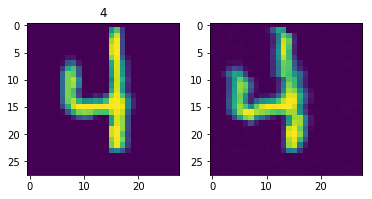

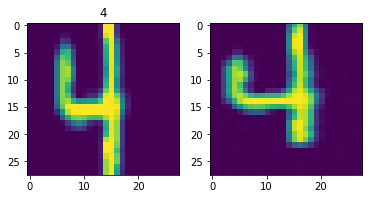

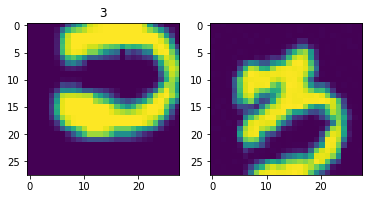

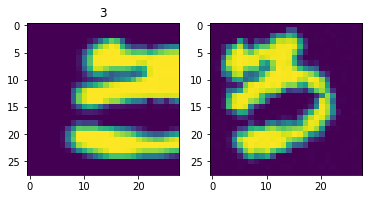

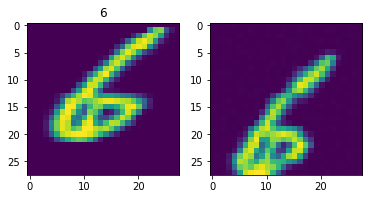

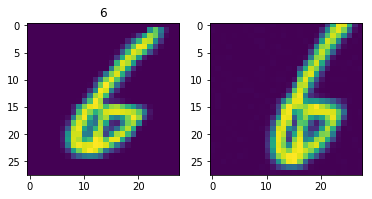

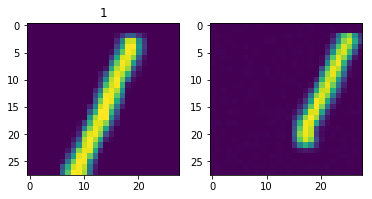

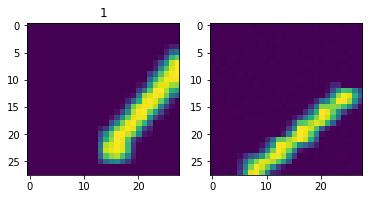

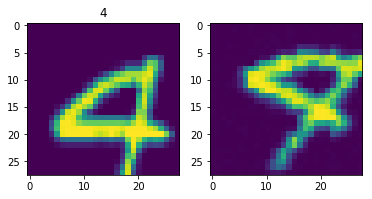

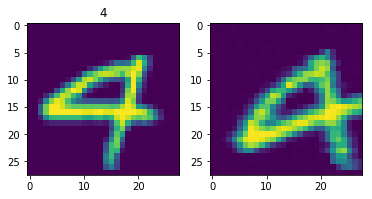

In [242]:
utils.plot_image_pairs(*next(iic_train_iterator), num_examples=10)

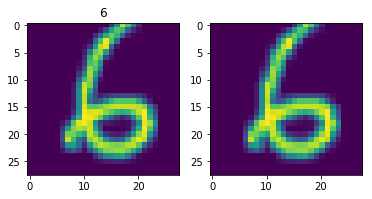

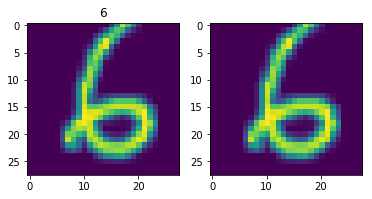

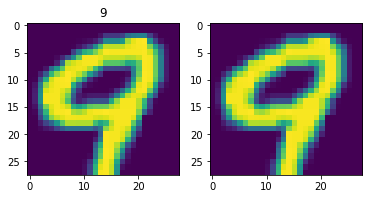

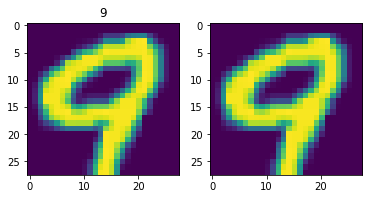

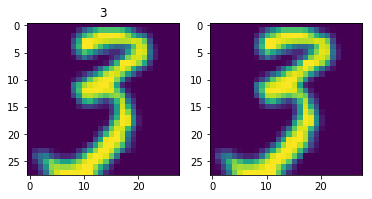

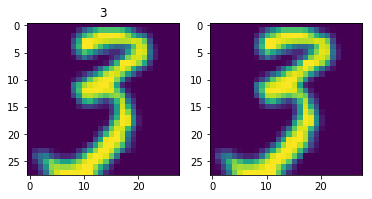

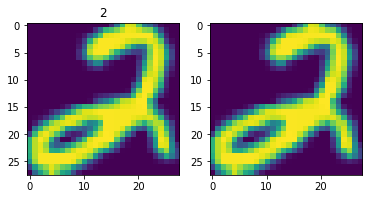

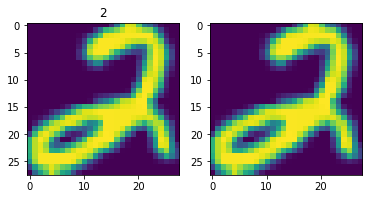

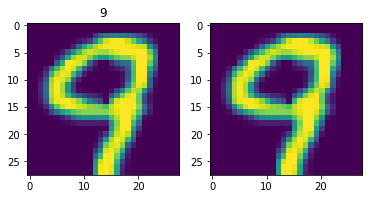

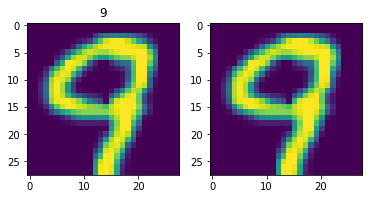

In [244]:
utils.plot_image_pairs(*next(iic_test_iterator), num_examples=10)

In [243]:
%timeit -n 10 next(iic_train_iterator)

The slowest run took 10.03 times longer than the fastest. This could mean that an intermediate result is being cached.
12.4 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [217]:
base_model = models.create_resnet_se_backbone(model_input_shape, (1, 1), attention=None)

In [218]:
base_model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 28, 28, 1)    3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_30 (ZeroPadding2 (None, 34, 34, 1)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 14, 14, 64)   3136        zero_padding2d_30[0][0]          
___________________________________________________________________________________________

In [219]:
inputs, main_heads, aux_heads = models.create_iic_model(
    base_model, 
    main_head_num_classes=num_classes, 
    aux_head_num_classes=5 * num_classes,
    num_main_heads=1,
    num_aux_heads=1
)

In [220]:
inputs, main_heads, aux_heads

({'image': <tf.Tensor 'image_6:0' shape=(?, 28, 28, 1) dtype=float32>,
  'tf_image': <tf.Tensor 'tf_image_7:0' shape=(?, 28, 28, 1) dtype=float32>},
 [{'outputs': [<tf.Tensor 'main_head_0/p_out_5/Identity:0' shape=(?, 10) dtype=float32>,
    <tf.Tensor 'main_head_0/p_tf_out_5/Identity:0' shape=(?, 10) dtype=float32>],
   'loss': <tf.Tensor 'main_head_0/iic_loss_5:0' shape=() dtype=float32>}],
 [{'outputs': [<tf.Tensor 'aux_head_0/p_out_5/Identity:0' shape=(?, 50) dtype=float32>,
    <tf.Tensor 'aux_head_0/p_tf_out_5/Identity:0' shape=(?, 50) dtype=float32>],
   'loss': <tf.Tensor 'aux_head_0/iic_loss_5:0' shape=() dtype=float32>}])

In [221]:
heads_p_out = [head['outputs'][0] for head in main_heads]
iic_main_model = keras.Model(inputs=inputs, outputs=[heads_p_out])

heads_p_out = [head['outputs'][0] for head in aux_heads]
iic_aux_model = keras.Model(inputs=inputs, outputs=[heads_p_out])

In [222]:
heads_p_out

[<tf.Tensor 'aux_head_0/p_out_5/Identity:0' shape=(?, 50) dtype=float32>]

In [223]:
main_heads_loss = tf.add_n([head['loss'] for head in main_heads]) / len(main_heads)
aux_heads_loss = tf.add_n([head['loss'] for head in aux_heads]) / len(aux_heads)
main_heads_loss, aux_heads_loss

(<tf.Tensor 'truediv_36:0' shape=() dtype=float32>,
 <tf.Tensor 'truediv_37:0' shape=() dtype=float32>)

In [224]:
iic_main_model.add_loss(main_heads_loss)
iic_aux_model.add_loss(aux_heads_loss)

In [253]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
iic_main_model.compile(optimizer=optimizer)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
iic_aux_model.compile(optimizer=optimizer)

In [254]:
iic_main_model.fit(
    iic_train_iterator, verbose=1, epochs=10,
    steps_per_epoch=num_train_steps, callbacks = [utils.PredictionsHistory(iic_test_iterator)]
)

Epoch 1/10
  1/937 [..............................] - ETA: 8:16:00 - loss: -1.9640WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.129674). Check your callbacks.


937/937 [==============================] - 70s 75ms/step - loss: -2.0792
Epoch 2/10
937/937 [==============================] - 39s 41ms/step - loss: -2.0942
Epoch 3/10
937/937 [==============================] - 39s 41ms/step - loss: -2.0955
Epoch 4/10
937/937 [==============================] - 39s 41ms/step - loss: -2.0954
Epoch 5/10
937/937 [==============================] - 39s 41ms/step - loss: -2.0978
Epoch 6/10
937/937 [==============================] - 39s 42ms/step - loss: -2.1048
Epoch 7/10
937/937 [==============================] - 39s 42ms/step - loss: -2.1005
Epoch 8/10
937/937 [==============================] - 39s 41ms/step - loss: -2.1025
Epoch 9/10
937/937 [==============================] - 39s 41ms/step - loss: -2.1058
Epoch 10/10
937/937 [==============================] - 39s 41ms/step - loss: -2.1066


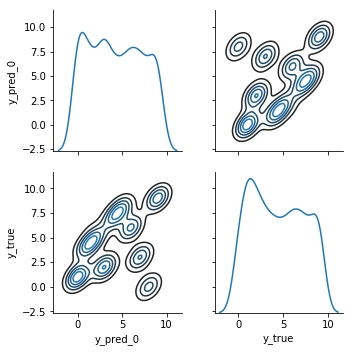

In [247]:
utils.plot_probabilities_grid(iic_main_model, iic_test_iterator)

In [249]:
# utils.plot_probabilities_grid(iic_main_model, iic_train_iterator)

In [210]:
iic_train_iterator.output_shapes

({'image': TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)]),
  'tf_image': TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])},
 {'label': TensorShape([Dimension(None)])})

In [250]:
image_input = keras.Input(shape=model_input_shape, name="tf_image")
h = keras.layers.GlobalAveragePooling2D()(base_model(image_input))
cls_output = keras.layers.Dense(10, activation="softmax", name="label")(h)

cls_model = keras.Model(inputs={"image": image_input}, outputs=cls_output)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
cls_model.compile(optimizer=optimizer, loss={"label": "sparse_categorical_crossentropy"})

In [251]:
# cls_model.summary()

In [252]:
cls_model.fit(
    iic_train_iterator, verbose=1, epochs=5,
    steps_per_epoch=num_train_steps, callbacks = [utils.PredictionsHistory(iic_test_iterator)]
)

Epoch 1/5
  1/937 [..............................] - ETA: 3:49:58 - loss: 4.5337WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.140815). Check your callbacks.


937/937 [==============================] - 35s 37ms/step - loss: 0.1559
Epoch 2/5
937/937 [==============================] - 20s 21ms/step - loss: 0.0824
Epoch 3/5
937/937 [==============================] - 20s 21ms/step - loss: 0.0777
Epoch 4/5
937/937 [==============================] - 20s 21ms/step - loss: 0.0738
Epoch 5/5
937/937 [==============================] - 20s 21ms/step - loss: 0.0717
